### IMPORTS

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### LOAD DATAFRAME

In [67]:
pd.options.display.max_columns = None
df = pd.read_csv('df_complete.csv')
df = df.drop('Unnamed: 0', axis=1)
df

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NICKNAME,VISITOR_TEAM_ABBREVIATION,VISITOR_TEAM_NICKNAME,SEASON,GAME_DATE,FG_PCT_home,FT_PCT_home,FG3_PCT_home,PERCENT_VIC_UNITL_THIS_GAME_HOME_TEAM,PERCENT_VIC_LAST5_GAMES_HOME_TEAM,PERCENT_VIC_LAST10_GAMES_HOME_TEAM,AVG_POINTS_UNTIL_THIS_GAME_HOME_TEAM,AVG_POINTS_LAST5_HOME_TEAM,AVG_POINTS_LAST10_HOME_TEAM,AVG_FGPERCENT_UNTIL_THIS_GAME_HOME_TEAM,AVG_FGPERCENT_LAST5_HOME_TEAM,AVG_FGPERCENT_LAST10_HOME_TEAM,AVG_FGPERCENT_LAST10_HOME_TEAM.1,AVG_FG3PCT_UNTIL_THIS_GAME_HOME_TEAM,AVG_FG3PCT_LAST5_HOME_TEAM,AVG_FG3PCT_LAST10_HOME_TEAM,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,PERCENT_VIC_UNITL_THIS_GAME_VISITOR_TEAM,PERCENT_VIC_LAST5_GAMES_VISITOR_TEAM,PERCENT_VIC_LAST10_GAMES_VISITOR_TEAM,AVG_POINTS_UNTIL_THIS_GAME_VISITOR_TEAM,AVG_POINTS_LAST5_VISITOR_TEAM,AVG_POINTS_LAST10_VISITOR_TEAM,AVG_FGPERCENT_UNTIL_THIS_GAME_VISITOR_TEAM,AVG_FGPERCENT_LAST5_VISITOR_TEAM,AVG_FGPERCENT_LAST10_VISITOR_TEAM,AVG_FGPERCENT_LAST10_VISITOR_TEAM.1,AVG_FG3PCT_UNTIL_THIS_GAME_VISITOR_TEAM,AVG_FG3PCT_LAST5_VISITOR_TEAM,AVG_FG3PCT_LAST10_VISITOR_TEAM,AST_away,REB_away,HOME_TEAM_WINS,VISITOR_TEAM_WINS,PTS_home,PTS_away
0,20300001,1610612755,1610612748,PHI,76ers,MIA,Heat,2003,2003-10-28,0.440,0.533,0.350,40.243902,20.0,30.0,87.987805,88.0,84.3,0.429683,0.4656,0.4251,0.4251,0.335171,0.2914,0.3069,25.0,39.0,0.408,0.824,0.250,51.219512,80.0,70.0,90.268293,94.0,93.6,0.426366,0.4210,0.4185,0.4185,0.358317,0.3632,0.3776,16.0,44.0,1,0,89.0,74.0
1,20300002,1610612759,1610612756,SAS,Spurs,PHX,Suns,2003,2003-10-28,0.425,0.769,0.100,69.512195,100.0,100.0,91.475610,87.8,94.1,0.442159,0.4760,0.4828,0.4828,0.358293,0.2832,0.3390,20.0,38.0,0.361,0.810,0.500,35.365854,60.0,50.0,94.182927,94.2,94.9,0.444463,0.4424,0.4537,0.4537,0.340049,0.4792,0.3745,14.0,43.0,1,0,83.0,82.0
2,20300003,1610612747,1610612742,LAL,Lakers,DAL,Mavericks,2003,2003-10-28,0.506,0.600,0.350,68.292683,60.0,70.0,98.195122,96.4,95.9,0.454000,0.4402,0.4456,0.4456,0.321244,0.2542,0.3458,32.0,46.0,0.376,0.733,0.280,63.414634,60.0,80.0,105.195122,105.0,113.8,0.460732,0.4686,0.5147,0.5147,0.347183,0.3966,0.4257,17.0,46.0,1,0,109.0,93.0
3,20300004,1610612738,1610612748,BOS,Celtics,MIA,Heat,2003,2003-10-29,0.507,0.731,0.313,43.902439,20.0,40.0,95.256098,98.8,97.8,0.444085,0.4358,0.4562,0.4562,0.342012,0.3174,0.3233,28.0,40.0,0.366,0.750,0.417,51.219512,80.0,70.0,90.268293,94.0,93.6,0.426366,0.4210,0.4185,0.4185,0.358317,0.3632,0.3776,14.0,39.0,1,0,98.0,75.0
4,20300005,1610612752,1610612753,NYK,Knicks,ORL,Magic,2003,2003-10-29,0.400,0.824,0.313,47.560976,60.0,60.0,91.975610,95.0,92.9,0.443159,0.4526,0.4425,0.4425,0.358354,0.3594,0.3615,20.0,48.0,0.368,0.552,0.250,25.609756,40.0,20.0,94.036585,88.8,89.2,0.429646,0.4318,0.4200,0.4200,0.341780,0.2478,0.3035,17.0,44.0,0,1,83.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,21801226,1610612749,1610612760,MIL,Bucks,OKC,Thunder,2018,2019-04-10,0.430,0.714,0.326,73.170732,60.0,70.0,118.121951,123.6,123.2,0.476805,0.4758,0.4821,0.4821,0.353244,0.3388,0.3713,27.0,53.0,0.485,0.615,0.426,59.756098,100.0,70.0,114.475610,122.6,114.7,0.454854,0.4720,0.4530,0.4530,0.351329,0.3874,0.3648,40.0,53.0,0,1,116.0,127.0
19394,21801227,1610612759,1610612742,SAS,Spurs,DAL,Mavericks,2018,2019-04-10,0.466,0.833,0.333,58.536585,80.0,60.0,111.658537,109.6,110.6,0.479598,0.4916,0.4828,0.4828,0.396671,0.3588,0.3472,22.0,53.0,0.407,0.750,0.297,40.243902,40.0,50.0,108.865854,112.6,113.7,0.447659,0.4402,0.4527,0.4527,0.341451,0.3062,0.3372,27.0,42.0,1,0,105.0,94.0
19395,21801228,1610612743,1610612750,DEN,Nuggets,MIN,Timberwolves,2018,2019-04-10,0.448,0.647,0.303,65.853659,60.0,50.0,110.670732,109.4,103.4,0.466951,0.4816,0.4518,0.4518,0.349707,0.3600,0.3077,23.0,53.0,0.429,0.667,0.406,43.902439,40.0,40.0,112.475610,108.4,112.7,0.457207,0.4752,0.4674

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve, f1_score, \
precision_score, recall_score, accuracy_score, precision_recall_curve, auc

from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [69]:
def evaluate_ROC(estimator, data, target):

    X_train, X_test, y_train, y_test = train_test_split(data,target)

    estimator.fit(X_train, y_train)
    y_hat = estimator.predict(X_test)
    probs = estimator.predict_proba(X_test)[:,1]

    # plotear curva roc
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    f, ax = plt.subplots(1,1)
    f.set_size_inches(8,7)
    ax.plot(fpr,tpr)
    ax.plot([0,1], [0,1], c='grey')

    print(f'acc: {accuracy_score(y_test, y_hat):.3} \
    recall: {recall_score(y_test, y_hat):.3} \
    precision:{precision_score(y_test, y_hat):.3} \
    f1:{f1_score(y_test, y_hat):.3} \
    auc:{roc_auc_score(y_test, probs):.3}')
    
    
def evaluate_PS(estimator, data, target):

    X_train, X_test, y_train, y_test = train_test_split(data,target)

    estimator.fit(X_train, y_train)
    y_hat = estimator.predict(X_test)
    probs = estimator.predict_proba(X_test)[:,1]

    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)
    lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)
    # Resumimos s
    print('Estimator: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
    plt.plot(lr_recall, lr_precision, marker='.', label=str(estimator))
    #Etiquetas de ejes
    plt.xlabel('Sensibilidad')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

In [70]:
X = df.iloc[:,9:44].values
y = df.iloc[:,45].values
y=y.astype('int')

X_copy = X.copy()
X_norm = (X_copy - X_copy.mean()) / X_copy.std()

# Gaussian

### Default parameters

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))

Accuracy %: 
78.47422680412372
----------------------------------------
Matrix Confusion: 
[[1482  477]
 [ 567 2324]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1959
           1       0.83      0.80      0.82      2891

    accuracy                           0.78      4850
   macro avg       0.78      0.78      0.78      4850
weighted avg       0.79      0.78      0.79      4850



acc: 0.777     recall: 0.805     precision:0.819     f1:0.812     auc:0.859
Estimator: f1=0.812 auc=0.903


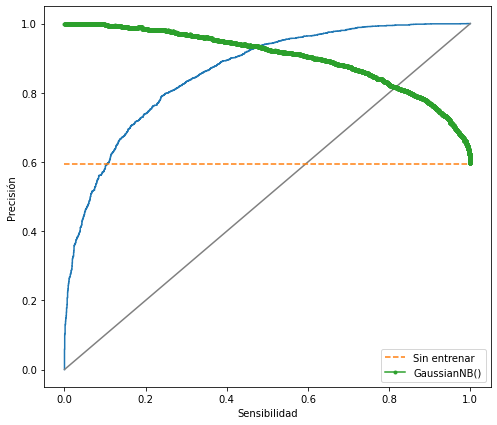

In [72]:
evaluate_ROC(gnb, X_norm, y)
evaluate_PS(gnb, X_norm, y)

### Gridsearch

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'var_smoothing' : [0.00000001, 0.000000001, 0.0000000001, 0.00000000001]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GaussianNB(),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)



# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
print("----------------------------------------")


modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))
print("----------------------------------------")
print("Best parameters: ")
print(grid.best_params_)
print(grid.best_score_)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'var_smoothing': 1e-08} : 0.7824901587166582 accuracy
----------------------------------------
Accuracy %: 
78.47422680412372
----------------------------------------
Matrix Confusion: 
[[1482  477]
 [ 567 2324]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1959
           1       0.83      0.80      0.82      2891

    accuracy                           0.78      4850
   macro avg       0.78      0.78      0.78      4850
weighted avg       0.79      0.78      0.79      4850

----------------------------------------
Best parameters: 
{'var_smoothing': 1e-08}
0.7824901587166582


acc: 0.79     recall: 0.808     precision:0.83     f1:0.819     auc:0.872
Estimator: f1=0.808 auc=0.897


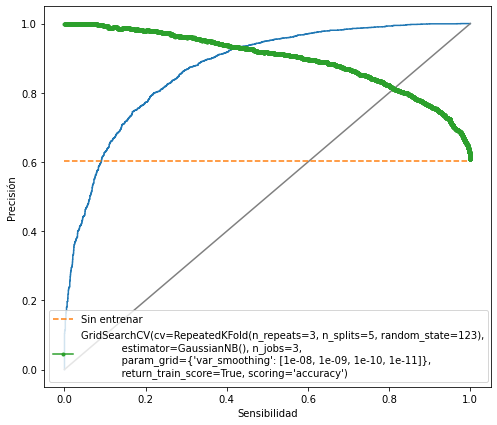

In [74]:
evaluate_ROC(grid, X_norm, y)
evaluate_PS(grid, X_norm, y)

# Logistic regression

### Default parameters

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logr = LogisticRegression()
logr.fit(X_train, y_train)

y_pred = logr.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))

Accuracy %: 
85.95876288659794
----------------------------------------
Matrix Confusion: 
[[1600  359]
 [ 322 2569]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1959
           1       0.88      0.89      0.88      2891

    accuracy                           0.86      4850
   macro avg       0.85      0.85      0.85      4850
weighted avg       0.86      0.86      0.86      4850



/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

acc: 0.778     recall: 0.85     precision:0.794     f1:0.821     auc:0.85
Estimator: f1=0.814 auc=0.890


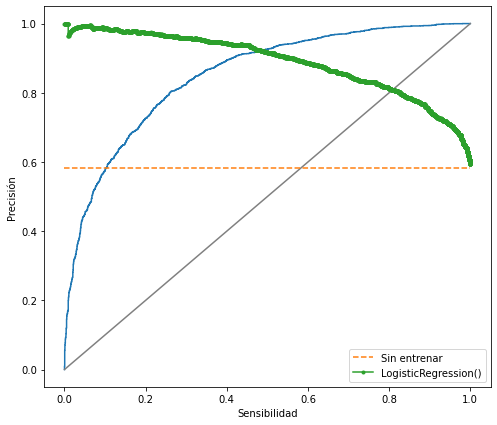

In [76]:
evaluate_ROC(logr, X_norm, y)
evaluate_PS(logr, X_norm, y)

### Gridsearch

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'C' : np.logspace(-4, 4, 50),
              'solver' : ['newton-cg', 'liblinear', 'sag', 'saga'],
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = LogisticRegression(max_iter=500),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)



# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
print("----------------------------------------")


modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))
print("----------------------------------------")
print("Best parameters: ")
print(grid.best_params_)
print(grid.best_score_)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 232.99518105153672, 'solver': 'sag'} : 0.8627760274725081 accuracy
----------------------------------------
Accuracy %: 
85.95876288659794
----------------------------------------
Matrix Confusion: 
[[1600  359]
 [ 322 2569]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1959
           1       0.88      0.89      0.88      2891

    accuracy                           0.86      4850
   macro avg       0.85      0.85      0.85      4850
weighted avg       0.86      0.86      0.86      4850

----------------------------------------
Best parameters: 
{'C': 232.99518105153672, 'solver': 'sag'}
0.8627760274725081


/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


acc: 0.813     recall: 0.87     precision:0.823     f1:0.846     auc:0.89
Estimator: f1=0.841 auc=0.914


/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


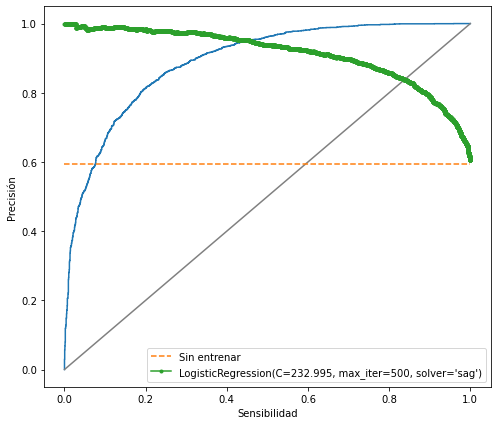

In [82]:
logr = LogisticRegression(max_iter=500, C=232.995, solver='sag')

evaluate_ROC(logr, X_norm, y)
evaluate_PS(logr, X_norm, y)

# SVC

### Default parameters

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, 
    y, 
    test_size=0.25, 
    random_state=0,
    shuffle = True)

svc = SVC(probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))

Accuracy %: 
76.57731958762886
----------------------------------------
Matrix Confusion: 
[[1246  713]
 [ 423 2468]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1959
           1       0.78      0.85      0.81      2891

    accuracy                           0.77      4850
   macro avg       0.76      0.74      0.75      4850
weighted avg       0.76      0.77      0.76      4850



acc: 0.765     recall: 0.853     precision:0.774     f1:0.811     auc:0.842
Estimator: f1=0.808 auc=0.881


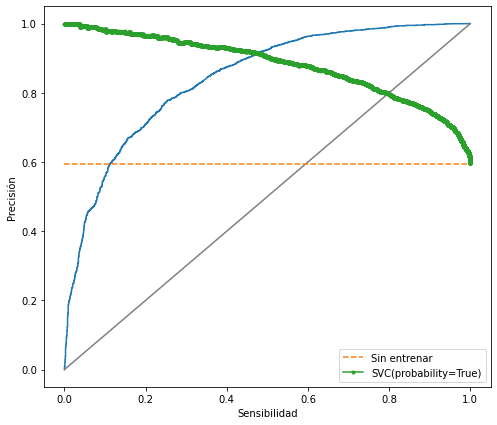

In [86]:
evaluate_ROC(svc, X_norm, y)
evaluate_PS(svc, X_norm, y)

### Gridsearch

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20),
              'kernel' : ['poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto']
             }

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(probability=True),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
print("----------------------------------------")


modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))
print("----------------------------------------")
print("Best parameters: ")
print(grid.best_params_)
print(grid.best_score_)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 0.26366508987303555, 'gamma': 'auto', 'kernel': 'rbf'} : 0.8583304879526654 accuracy
----------------------------------------
Accuracy %: 
85.89690721649484
----------------------------------------
Matrix Confusion: 
[[1577  382]
 [ 302 2589]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1959
           1       0.87      0.90      0.88      2891

    accuracy                           0.86      4850
   macro avg       0.86      0.85      0.85      4850
weighted avg       0.86      0.86      0.86      4850

----------------------------------------
Best parameters: 
{'C': 0.26366508987303555, 'gamma': 'auto', 'kernel': 'rbf'}
0.8583304879526654


In [88]:
evaluate_ROC(grid, X_norm, y)
evaluate_PS(grid, X_norm, y)

KeyboardInterrupt: 

# Decision Tree

### Default parameters

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)


print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))

print(f"Profundidad del árbol: {dtc.get_depth()}")
print(f"Número de nodos terminales: {dtc.get_n_leaves()}")
importancia_predictores = pd.DataFrame(
                            {'importancia': dtc.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
print(importancia_predictores.sort_values('importancia', ascending=False).head(3))

% de acierto: 
75.01030927835052
-------------------
Matrix Confusion: 
[[1375  584]
 [ 628 2263]]
-------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1959
           1       0.79      0.78      0.79      2891

    accuracy                           0.75      4850
   macro avg       0.74      0.74      0.74      4850
weighted avg       0.75      0.75      0.75      4850

-------------------
Profundidad del árbol: 23
Número de nodos terminales: 1526
Importancia de los predictores en el modelo
-------------------------------------------
    importancia
18     0.222056
0      0.218326
3      0.050699


Las columnas 0 y 18 del dataset X corresponden con 'FG_PCT_home' y 'FG_PCT_away' respectivamente

In [ ]:
evaluate_ROC(dtc, X_norm, y)
evaluate_PS(dtc, X_norm, y)

### Gridsearch

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Grid de hiperparámetros
# ==============================================================================
param_grid = {'ccp_alpha':np.linspace(0, 5, 10),
              'criterion' : ["gini", "entropy"],
              'max_features' : ["auto", "sqrt", "log2"],
              }

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = DecisionTreeClassifier(),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
print("----------------------------------------")


modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))
print("----------------------------------------")
print("Best parameters: ")
print(grid.best_params_)
print(grid.best_score_)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'auto'} : 0.7408570725958304 accuracy
----------------------------------------
% de acierto: 
0.7498969072164948
----------------------------------------
Matrix Confusion: 
[[1358  601]
 [ 612 2279]]
----------------------------------------
Clasification report: 
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1959
           1       0.79      0.79      0.79      2891

    accuracy                           0.75      4850
   macro avg       0.74      0.74      0.74      4850
weighted avg       0.75      0.75      0.75      4850



In [35]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")
importancia_predictores = pd.DataFrame(
                            {'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
print(importancia_predictores.sort_values('importancia', ascending=False).head(10))

Profundidad del árbol: 25
Número de nodos terminales: 2198
Importancia de los predictores en el modelo
-------------------------------------------
    importancia
0      0.144664
18     0.109152
2      0.069776
17     0.057049
20     0.045286
3      0.038406
21     0.032289
34     0.031109
1      0.029013
27     0.025173


In [ ]:
evaluate_ROC(grid, X_norm, y)
evaluate_PS(grid, X_norm, y)

# Random Forest

### Default parameters

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))

% de acierto: 
0.8441237113402061
Matrix Confusion: 
[[1528  431]
 [ 325 2566]]
Clasification report: 
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1959
           1       0.86      0.89      0.87      2891

    accuracy                           0.84      4850
   macro avg       0.84      0.83      0.84      4850
weighted avg       0.84      0.84      0.84      4850



In [ ]:
evaluate_ROC(rfc, X_norm, y)
evaluate_PS(rfc, X_norm, y)

### Gridsearch

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'max_depth'    : [None, 3, 10, 20],
              'criterion'    : ['gini', 'entropy'],
              'max_features' : ["auto", "sqrt", "log2"],
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
print("----------------------------------------")


modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X_test)

print("Accuracy %: ")
print(np.mean(y_pred == y_test)*100)
print("----------------------------------------")
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("----------------------------------------")
print("Clasification report: ")
print(classification_report(y_test,y_pred))
print("----------------------------------------")
print("Best parameters: ")
print(grid.best_params_)
print(grid.best_score_)

KeyboardInterrupt: 

In [ ]:
evaluate_ROC(grid, X_norm, y)
evaluate_PS(grid, X_norm, y)

# ---------------------------------------------------------------------------------------------------------------

# Resumen en tabla de los algoritmos, parametros y score (default, grid and random)

# ---------------------------------------------------------------------------------------------------------------

In [144]:
#Dataframe de resultados de accuracy
columnas_opt = ['Tecnica','Gaussian','Logistic Regression','SVC','Decissin Tree Classifier','Random Forest Classifier']
df_opt = pd.DataFrame(columns = columnas_opt)
df_opt.set_index("Tecnica",inplace=True)
df_opt.loc['Standard'] = [0, 0, 0, 0, 0]
df_opt.loc['GridSearch'] = [0, 0, 0, 0, 0]
df_opt.loc['RandomSearch'] = [0, 0, 0, 0, 0]
df_opt.loc['Hyperopt'] = [0, 0, 0, 0, 0]
df_opt.head()

columnas_ps = ['Estimator', 'Params', 'Score']
df_params_scores = pd.DataFrame(columns = columnas_ps,)

X = df.iloc[:,9:44].values
y = df.iloc[:,45].values
y=y.astype('int')

X_copy = X.copy()
X_norm = (X_copy - X_copy.mean()) / X_copy.std()

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 1. Default Parameters

In [145]:
gnb = GaussianNB()
logR = LogisticRegression()
svc = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()


models = [gnb,logR,svc,dtc,rfc]


col = 0
for model in models:
    model.fit(X_train,y_train)
    df_opt.iloc[0,col] = model.score(X_test,y_test)
    col += 1

df_opt.head()

,Gaussian,Logistic Regression,SVC,Decissin Tree Classifier,Random Forest Classifier
Tecnica,,,,,
Standard,0.784742,0.859588,0.85732,0.755876,0.852577
GridSearch,0,0,0,0,0
RandomSearch,0,0,0,0,0
Hyperopt,0,0,0,0,0


### 2. GridSearchCV

In [146]:
#Gaussian
var_smoothing = [0.00000001, 0.000000001, 0.0000000001]

gnb_grid = dict(var_smoothing = var_smoothing)


#Logistic Regression
C = np.logspace(-4, 4, 50)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

logR_grid = dict(C = C,
                 solver = solver)



#SVC
C = np.logspace(-5, 7, 20)
kernel = ['poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

svc_grid = dict(C = C,
                kernel = kernel,
                gamma = gamma)


#Decission Tree Classifier
ccp_alpha = np.linspace(0, 5, 10)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]

dtc_grid = dict(ccp_alpha = ccp_alpha,
                criterion = criterion,
                max_features = max_features,)


# Random Forest Classifier
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
max_depth = [None, 3, 10, 20]
criterion = ['gini', 'entropy']
max_features = ["auto", "sqrt", "log2"]

rfc_grid = dict(n_estimators=n_estimators, 
                max_depth=max_depth,
                criterion=criterion,
                max_features=max_features)



#--------------------------------------#
models = [gnb,logR,svc,dtc,rfc]
grids = [gnb_grid,logR_grid,svc_grid,dtc_grid,rfc_grid]
col = 0
fila_aux = 0

for ind in range(0,len(models)):
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3, 
                                 random_state=1)
    
    grid_search = GridSearchCV(estimator=models[col],
                               param_grid=grids[col], 
                               n_jobs=-1, 
                               cv=cv,
                               scoring='accuracy',
                               error_score=0)
    
    grid_clf_acc = grid_search.fit(X_train, y_train)
    df_opt.iloc[1,col] = grid_clf_acc.score(X_test,y_test)
    
    
    df_params_scores.loc[fila_aux, 'Estimator'] = grid_clf_acc.estimator
    df_params_scores.loc[fila_aux, 'Params'] = str(grid_clf_acc.best_params_)
    df_params_scores.loc[fila_aux, 'Score'] = grid_clf_acc.best_score_
    
    
    col += 1
    fila_aux += 1

df_opt.head()

,Gaussian,Logistic Regression,SVC,Decissin Tree Classifier,Random Forest Classifier
Tecnica,,,,,
Standard,0.784742,0.859588,0.85732,0.755876,0.852577
GridSearch,0.784742,0.859794,0.858969,0.74433,0.857732
RandomSearch,0,0,0,0,0
Hyperopt,0,0,0,0,0


In [147]:
df_params_scores.to_csv('df_params_scores_grid.csv')

### 3. RandomizedSearchCV

In [148]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [149]:
columnas_ps = ['Estimator', 'Params', 'Score']
df_params_scores_random = pd.DataFrame(columns = columnas_ps)

In [150]:
col = 0
for ind in range(0,len(models)):
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3,
                                 random_state=1)
    n_iter_search = 3
    random_search = RandomizedSearchCV(models[col],
                                       param_distributions=grids[col],
                                       n_iter=n_iter_search, 
                                       cv=cv)
    
    random_search.fit(X_train,y_train)
    df_opt.iloc[2,col] = random_search.score(X_test,y_test)
    
    df_params_scores_random.loc[fila_aux, 'Estimator'] = random_search.estimator
    df_params_scores_random.loc[fila_aux, 'Params'] = str(random_search.best_params_)
    df_params_scores_random.loc[fila_aux, 'Score'] = random_search.best_score_
    
    col += 1
    fila_aux += 1
    
df_opt.head()

,Gaussian,Logistic Regression,SVC,Decissin Tree Classifier,Random Forest Classifier
Tecnica,,,,,
Standard,0.784742,0.859588,0.85732,0.755876,0.852577
GridSearch,0.784742,0.859794,0.858969,0.74433,0.857732
RandomSearch,0.784742,0.859794,0.830309,0.596082,0.848041
Hyperopt,0,0,0,0,0


In [151]:
df_params_scores_random.to_csv('df_params_scores_random.csv')

In [33]:
df_grid = pd.read_csv('df_params_scores_grid.csv')
df_grid = df_grid.drop('Unnamed: 0', axis=1)

df_random = pd.read_csv('df_params_scores_random.csv')
df_random = df_random.drop('Unnamed: 0', axis=1)

df_params = pd.concat([df_grid, df_random], ignore_index=True)
df_params = df_params.sort_values(by='Score', ascending = False)
df_params

,Estimator,Params,Score
1,LogisticRegression(),"{'C': 0.3906939937054613, 'solver': 'newton-cg'}",0.862707
6,LogisticRegression(),"{'solver': 'sag', 'C': 0.5689866029018293}",0.862639
2,SVC(),"{'C': 0.26366508987303555, 'gamma': 'auto', 'k...",0.859614
4,RandomForestClassifier(),"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.848203
9,RandomForestClassifier(),"{'n_estimators': 200, 'max_features': 'auto', ...",0.842979
7,SVC(),"{'kernel': 'sigmoid', 'gamma': 'auto', 'C': 0....",0.826116
0,GaussianNB(),{'var_smoothing': 1e-08},0.782284
5,GaussianNB(),{'var_smoothing': 1e-08},0.782284
3,DecisionTreeClassifier(),"{'ccp_alpha': 0.0, 'criterion': 'entropy', 'ma...",0.737995
8,DecisionTreeClassifier(),"{'max_features': 'sqrt', 'criterion': 'gini', ...",0.594515


# ---------------------------------------------------------------------------------------------------------------

# Creación modelo final:

# ---------------------------------------------------------------------------------------------------------------